In [0]:
def import_data(url):
  import pandas as pd
  df = pd.read_csv(url)
  
  # Drop columns not used in model 
    # user_facebook_id, user_profile_url, social_share_last_update - high majority null
    # url, default_url, campaign_image_url, user_profile_url, user_first_name, user_last_name, collected_date - probably won't effect prediction
    # velocity - only 1 value
    # turn_off_donations, deactivated, status, media_type, project_type, category, state, is_launched - majority 1 value
    #, 'user_first_name', 'user_last_name'
  df.drop(columns=["user_facebook_id", 'status', 'media_type', 'state', 'collected_date', 'is_launched', 'category', 'project_type', 'Unnamed: 0', "user_profile_url","social_share_last_update", "url", 'deactivated', "default_url", 'campaign_image_url', 'user_profile_url', 'velocity', 'turn_off_donations'], inplace=True)

  # Replace nulls in charity_npo_id with 0
  # Replace nulls in charity_name, description with N/A
  df.charity_npo_id.fillna(0, inplace=True)
  df.charity_name.fillna("N/A", inplace=True)
  df.description.fillna("N/A", inplace=True)

  # cast as bool instead of string 
  df.auto_fb_post_mode = df.auto_fb_post_mode.astype(bool)
  df.visible_in_search = df.visible_in_search.astype(bool)
  df.charity_valid = df.charity_valid.astype(bool)

  # take year of created date, drop every row that wasn't created in 2020
  year = df.created_at.str[:4]
  df['ld_year'] = year 
  df.drop(df[df['ld_year'] != '2020'].index, inplace=True)
  df.drop(columns=['ld_year'], inplace=True)

  # separate city and state
  city = df.location_city.str.split(',').str[0]
  state = df.location_city.str.split(',').str[1]

  df['location_city'] = city
  df['location_state'] = state   

  #feature engineering
    #percent of goal
  df['percent_of_goal'] = df.current_amount / df.goal
    #convert everything to USD
  df['current_amount_USD'] = 0
  df.loc[df['currencycode'] == 'USD', 'current_amount_USD'] = df.current_amount
  df.loc[df['currencycode'] == 'EUR', 'current_amount_USD'] = df.current_amount*0.92  #conversion rates at point in time
  df.loc[df['currencycode'] == 'GBP', 'current_amount_USD'] = df.current_amount*0.81
  df.loc[df['currencycode'] == 'CAD', 'current_amount_USD'] = df.current_amount*1.4
  df.loc[df['currencycode'] == 'AUD', 'current_amount_USD'] = df.current_amount*1.62
  df.loc[df['currencycode'] == 'CHF', 'current_amount_USD'] = df.current_amount*0.97
  df.loc[df['currencycode'] == 'SEK', 'current_amount_USD'] = df.current_amount*10.03
  df.loc[df['currencycode'] == 'NOK', 'current_amount_USD'] = df.current_amount*10.24
  df.loc[df['currencycode'] == 'DKK', 'current_amount_USD'] = df.current_amount*6.85

  #amount per donation
  df['amount_per_donation'] = df.current_amount_USD / df.donators
  df.loc[df['donators'] == 0, 'amount_per_donation'] = 0
  df.loc[df['current_amount_USD'] == 0, 'amount_per_donation'] = 0  

    # get rid of any campaigns that just have the name corona
  for row in df.iterrows():
    if ('corona' in row[1][13] or 'Corona' in row[1][13] or 'corona' in str(row[1][14]) or 'Corona' in str(row[1][14])):
        if not ('coronavirus' in row[1][10] or 'Corona Virus' in row[1][10] or 'Coronavirus' in row[1][10] or 'Corona Virus' in row[1][10] or 'Covid-19' in row[1][10] or 'covid-19' in row[1][10] or 'COVID-19' in row[1][10]):
            df.drop([row[0]], inplace=True)

  df.drop(columns=['user_first_name', 'user_last_name'], inplace=True) 


# get rid of line breaks..hopefully
  df.description = df.description.replace('\n', ' ', regex=True).replace('\r', ' ', regex=True).replace(',', '', regex=True)

  for col in df:
    if col[0].isdigit():
      nums = ['zero', 'one', 'two','three','four','five','six', 'seven', 'eight', 'nine']
      df.rename(columns={col:nums[int(col[0])] + '_' + col}, inplace=True)

  return df

df = import_data("/content/drive/My Drive/Colab Notebooks/data/campaigns.csv")  
label = ''
df.head()

,campaign_id,auto_fb_post_mode,category_id,currencycode,current_amount,goal,donators,days_active,days_created,title,description,has_beneficiary,user_id,visible_in_search,created_at,launch_date,campaign_hearts,social_share_total,location_city,location_country,location_zip,is_charity,charity_valid,charity_npo_id,charity_name,location_state,percent_of_goal,current_amount_USD,amount_per_donation
349,44439552,False,18,EUR,705,2000,33,79.0,79.0,Emergenza Covid19 nelle comunità masai Tanzania,Siamo Cristina e Ilaria due amiche co...,True,39364012,True,2020-01-01T12:13:59-06:00,2020-01-01T14:01:30-06:00,32,108,NaN,IT,54100 Massa,False,False,0.0,N/A,NaN,0.352500,648.6,19.654545
350,43814064,False,2,USD,250,8800,2,105.0,105.0,Home Repairs -Job Loss due to Corona Virus,It all started in 2017 the gutters on my 1960 ...,False,43557168,False,2020-01-01T16:10:02-06:00,2019-12-02T16:13:55-06:00,0,0,Fullerton,US,92835,False,False,0.0,N/A,CA,0.028409,250.0,125.000000
353,44478460,False,11,USD,0,500,0,3.0,70.0,Coronavirus Covid19 2Seattle Residents Need Help,My wife and I live in king county Washington w...,False,44213524,True,2020-01-03T08:42:44-06:00,2020-03-10T09:32:28-05:00,0,0,Kent,US,98031,False,False,0.0,N/A,WA,0.000000,0.0,0.000000
354,44472302,False,9,USD,125,1000,2,74.0,74.0,Raising money for a great friend Rolando,Sad news that we announce the passing of Rolan...,False,44207472,False,2020-01-04T23:05:37-06:00,2020-01-02T23:14:05-06:00,2,0,San Jose,US,95112,False,False,0.0,N/A,CA,0.125000,125.0,62.500000
355,44516468,False,11,USD,100,60000,4,79.0,79.0,Help Qiánzài-el Liver Transplant Surgery/ Corona,We’re in dire need of help in raising funds fo...,False,44251166,False,2020-01-04T23:25:39-06:00,2020-01-04T23:34:49-06:00,4,0,Miami,US,33136,False,False,0.0,N/A,FL,0.001667,100.0,25.000000


In [0]:
def unistats(df):
  import pandas as pd
  
  pd.set_option('display.max_rows', 100)
  pd.set_option('display.max_columns', 100)
  
  output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'Numeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])

  for col in df:
    if pd.api.types.is_numeric_dtype(df[col]):
      output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, pd.api.types.is_numeric_dtype(df[col]), df[col].mode()[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt()]
    else:
      output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, pd.api.types.is_numeric_dtype(df[col]), df[col].mode()[0], '-', '-', '-', '-', '-', '-', '-', '-', '-']
  return output_df.sort_values(by=['Numeric', 'Skew', 'Unique'], ascending=False)

#Test the function
unistats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
auto_fb_post_mode,6038,0,2,bool,True,False,0.000165618,False,0,0,0,True,0.0128693,77.7046,6038
percent_of_goal,6038,0,2128,float64,True,0,2.81423,0,0,0.01,0.150375,9485,130.439,66.5827,4702.08
amount_per_donation,6038,0,2440,float64,True,0,52.49,0,0,19.0019,51.5864,26777.6,403.363,51.9209,3259.85
donators,6038,0,332,int64,True,0,41.1395,0,0,2,15,24295,394.341,43.5292,2465.21
campaign_hearts,6038,0,330,int64,True,0,40.2461,0,0,2,15,23732,386.097,43.3554,2446.19
social_share_total,6038,0,659,int64,True,0,140.43,0,0,0,40,66279,1101.82,39.8404,2210.61
goal,6038,0,315,int64,True,10000,2.34878e+06,1,2000,8000,25000,1000000000,4.24226e+07,22.384,514.363
current_amount,6038,0,1495,int64,True,0,2007.41,0,0,81.5,804.25,489043,12817.1,20.2958,562.814
current_amount_USD,6038,0,1924,float64,True,0,1961.29,0,0,80,795,449920,11987.4,19.4891,527.459
category_id,6038,0,20,int64,True,11,8.94982,0,2,8,11,342,16.8842,17.8007,348.457


In [0]:
# drop remaining rows with nulls values. not worth messsing with lol

df.dropna(axis=0, inplace=True)
unistats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
auto_fb_post_mode,5579,0,2,bool,True,False,0.000179244,False,0,0,0,True,0.0133882,74.6927,5579
percent_of_goal,5579,0,1994,float64,True,0,2.99103,0,0,0.01,0.15,9485,135.669,64.0419,4348.27
amount_per_donation,5579,0,2253,float64,True,0,53.9307,0,0,19.6269,52.5857,26777.6,418.974,50.1306,3030.28
donators,5579,0,304,int64,True,0,37.2285,0,0,2,15,24295,384.002,48.8758,2929.83
campaign_hearts,5579,0,301,int64,True,0,36.4241,0,0,2,14,23732,376.049,48.6543,2904.9
social_share_total,5579,0,608,int64,True,0,128.127,0,0,0,39,66279,1068.44,44.8563,2656.94
goal,5579,0,302,int64,True,10000,2.15666e+06,1,2000,8000,25000,1000000000,3.98701e+07,23.5779,574.487
current_amount,5579,0,1395,int64,True,0,1869.47,0,0,80,800,489043,12097.6,22.7621,708.297
current_amount_USD,5579,0,1793,float64,True,0,1840.05,0,0,80,790,449920,11353.4,21.6666,654.899
category_id,5579,0,20,int64,True,11,8.86503,0,2,8,11,342,16.9161,17.8031,347.937


In [0]:
# correct for skewness

import numpy as np
from matplotlib import pyplot as plt
df.loc[df['percent_of_goal'] > 1, 'percent_of_goal' ] = 1

df['donators_lnplus'] = np.log(df['donators'] + 1)
df.drop(columns='donators', inplace=True)
df['campaign_hearts_lnplus'] = np.log(df['campaign_hearts'] + 1)
df.drop(columns='campaign_hearts', inplace=True)
df['social_share_total_lnplus'] = np.log(df['social_share_total'] + 1)
df.drop(columns='social_share_total', inplace=True)
df['goal_lnplus'] = np.log(df['goal'] + 1)
df.drop(columns='goal', inplace=True)
df['current_amount_lnplus'] = np.log(df['current_amount'] + 1)
df.drop(columns='current_amount', inplace=True)
df['days_created_cub'] = df['days_created']**(1/3)
df.drop(columns='days_created', inplace=True)
df['days_active_cub'] = df['days_active']**(1/3)
df.drop(columns='days_active', inplace=True)

df['percent_of_goal_cub'] = df['percent_of_goal']**(1/3)
#df.drop(columns='percent_of_goal', inplace=True)
df['current_amount_USD_lnplus'] = np.log(df['current_amount_USD'] + 1)
#df.drop(columns='current_amount_USD', inplace=True)
df['amount_per_donation_lnplus'] = np.log(df['amount_per_donation'] + 1)
#df.drop(columns='amount_per_donation', inplace=True)

unistats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
auto_fb_post_mode,5579,0,2,bool,True,False,0.000179244,False,0,0,0,True,0.0133882,74.6927,5579
amount_per_donation,5579,0,2253,float64,True,0,53.9307,0,0,19.6269,52.5857,26777.6,418.974,50.1306,3030.28
current_amount_USD,5579,0,1793,float64,True,0,1840.05,0,0,80,790,449920,11353.4,21.6666,654.899
category_id,5579,0,20,int64,True,11,8.86503,0,2,8,11,342,16.9161,17.8031,347.937
charity_npo_id,5579,0,213,float64,True,0,86135.4,0,0,0,0,3.89081e+06,464673,5.79077,34.4334
has_beneficiary,5579,0,2,bool,True,False,0.0329808,False,0,0,0,True,0.178602,5.23158,25.3786
is_charity,5579,0,2,bool,True,False,0.0449901,False,0,0,0,True,0.207301,4.39142,17.2908
charity_valid,5579,0,2,bool,True,False,0.0449901,False,0,0,0,True,0.207301,4.39142,17.2908
percent_of_goal,5579,0,1852,float64,True,0,0.139807,0,0,0.01,0.15,1,0.252864,2.14549,3.71517
social_share_total_lnplus,5579,0,608,float64,True,0,1.53966,0,0,0,3.68888,11.1016,2.34728,1.13161,-0.162678


In [0]:
# Create t-score "success" variable. combination of percent of goal and amount/donation

# Calculate the mu (mean of the entire population) for each of our four factors:
df['percent_of_goal_score'] = (((df['percent_of_goal_cub']-df['percent_of_goal_cub'].mean())/df['percent_of_goal_cub'].std())*10) + 50
df['amt_per_donor_score'] = (((df['amount_per_donation_lnplus']-df['amount_per_donation_lnplus'].mean())/df['amount_per_donation_lnplus'].std())*10) + 50
df['success_score'] = (df['percent_of_goal_score'] + df['amt_per_donor_score'])/2
print('Percent of goal score: ')
print('Mean: ' + str(df['percent_of_goal_score'].mean()))
print('Min: ' + str(df['percent_of_goal_score'].min()))
print('Median: ' + str(df['percent_of_goal_score'].median()))
print('Max: ' + str(df['percent_of_goal_score'].max()))
print('\nAmount per donor score: ')
print('Mean: ' + str(df['amt_per_donor_score'].mean()))
print('Min: ' + str(df['amt_per_donor_score'].min()))
print('Median: ' + str(df['amt_per_donor_score'].median()))
print('Max: ' + str(df['amt_per_donor_score'].max()))
print('\nSuccess score: ')
print('Mean: ' + str(df['success_score'].mean()))
print('Min: ' + str(df['success_score'].min()))
print('Median: ' + str(df['success_score'].median()))
print('Max: ' + str(df['success_score'].max()))

Percent of goal score: 
Mean: 50.00000000000154
Min: 40.64082413131156
Median: 47.414547821607535
Max: 72.08166437416767

Amount per donor score: 
Mean: 49.99999999999875
Min: 38.1708761855315
Median: 53.44213909761389
Max: 89.61346634644835

Success score: 
Mean: 50.00000000000018
Min: 39.40585015842153
Median: 51.50459663505366
Max: 75.68487965891146


In [0]:
# manage outliers
import pandas as pd

outliers = pd.DataFrame(columns=['min', 'count below', 'max', 'count above'])

# Loop through each column in the dataframe except those that are: 1) categorical, 2) empty, or 3) binary (0/1)
for col in df:
  if pd.api.types.is_numeric_dtype(df[col]) and (len(df[col].value_counts()) > 0) and not all(df[col].value_counts().index.isin([0, 1])) and ('id' not in col):
    # Calculate the theoretical min/max
    min = df[col].mean() - (df[col].std() * 3)
    max = df[col].mean() + (df[col].std() * 3)
    df.loc[df[col] > max, col] = max
    df.loc[df[col] < min, col] = min

# Let's take a look to make sure it works
outliers

,min,count below,max,count above


In [0]:
unistats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
auto_fb_post_mode,5579,0,2,bool,True,False,0.000179244,False,0,0,0,True,0.0133882,74.6927,5579
category_id,5579,0,20,int64,True,11,8.86503,0,2,8,11,342,16.9161,17.8031,347.937
amount_per_donation,5579,0,2239,float64,True,0,43.9128,0,0,19.6269,52.5857,1310.85,100.466,7.91294,83.743
current_amount_USD,5579,0,1748,float64,True,0,1381.08,0,0,80,790,35900.3,4466.25,5.8624,38.1506
charity_npo_id,5579,0,213,float64,True,0,86135.4,0,0,0,0,3.89081e+06,464673,5.79077,34.4334
has_beneficiary,5579,0,2,bool,True,False,0.0329808,False,0,0,0,True,0.178602,5.23158,25.3786
is_charity,5579,0,2,bool,True,False,0.0449901,False,0,0,0,True,0.207301,4.39142,17.2908
charity_valid,5579,0,2,bool,True,False,0.0449901,False,0,0,0,True,0.207301,4.39142,17.2908
percent_of_goal,5579,0,1803,float64,True,0,0.136482,0,0,0.01,0.15,0.898399,0.241995,2.02973,3.0671
social_share_total_lnplus,5579,0,594,float64,True,0,1.53794,0,0,0,3.68888,8.58149,2.34166,1.11841,-0.235646


In [0]:
df.to_csv("/content/drive/My Drive/Colab Notebooks/data/campaignsClean.csv")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


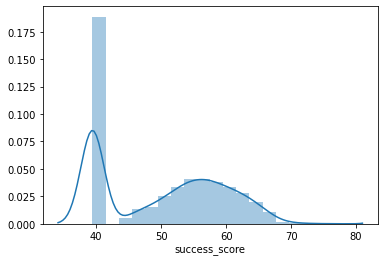

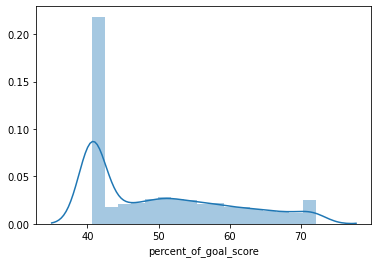

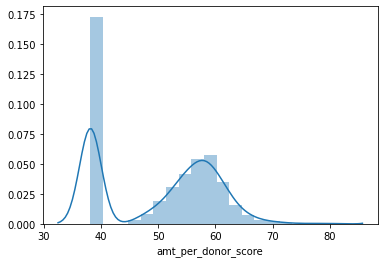

In [0]:
# distribution of scores

import seaborn as sns

sns.distplot(df.success_score)
plt.show()
sns.distplot(df.percent_of_goal_score)
plt.show()
sns.distplot(df.amt_per_donor_score)
plt.show()